In [107]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [129]:
mg_noIBX_abs = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_abs.csv', index_col=0).fillna(0)
mg_noIBX_norm = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_norm.csv', index_col=0).fillna(0)
mg_noIBX_log = pd.read_csv('/Users/turbold/Documents/CUSP/ADS/IBXRidership/mg_noIBX_log.csv', index_col=0).replace([np.inf, -np.inf], np.nan).fillna(mg_noIBX_log.mean())

In [130]:
cols_offpeak = ['cs_noibx_offpeak','lotarea', 'bldgarea',
                'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
                'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
                'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
                'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
                'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
                'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
                'vacant_homes_num', 'Bus_Stops']

cols_peak = ['cs_noibx_peak','lotarea', 'bldgarea',
             'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
             'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
             'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
             'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
             'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
             'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
             'vacant_homes_num', 'Bus_Stops']
             
mg_noIBX_abs.columns

Index(['complex_id', 'Stop Name', 'Complex_id', 'exits_weekday_evening',
       'entries_weekday_evening', 'exits_weekday_morning',
       'entries_weekday_morning', 'exits_weekday_overnight',
       'entries_weekday_overnight', 'exits_weekend_evening',
       'entries_weekend_evening', 'exits_weekend_morning',
       'entries_weekend_morning', 'exits_weekend_overnight',
       'entries_weekend_overnight', 'cs_ibx_peak', 'cs_ibx_offpeak',
       'cs_noibx_peak', 'cs_noibx_offpeak', 'VoroID', 'lotarea', 'bldgarea',
       'comarea', 'resarea', 'officearea', 'retailarea', 'garagearea',
       'strgearea', 'factryarea', 'otherarea', 'numbldgs', 'numfloors',
       'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops', 'geometry', 

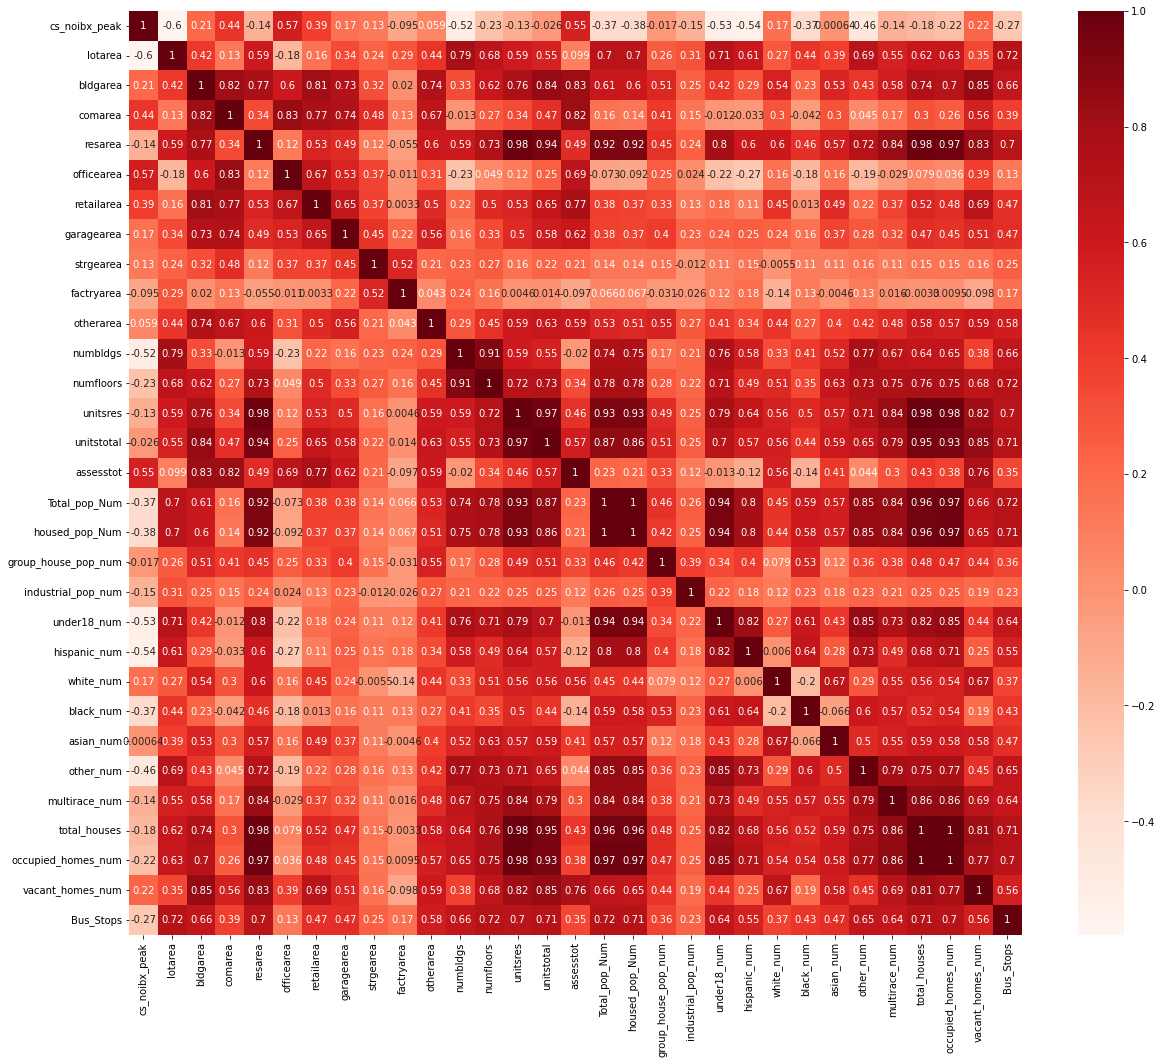

In [110]:
#Using Pearson Correlation
plt.figure(figsize=(20,17))
cor = mg_noIBX_log[cols_peak].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig('/Users/turbold/Documents/CUSP/ADS/IBX_cov_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

In [111]:
turnstile_data =['exits_weekday_evening',
       'entries_weekday_evening', 'exits_weekday_morning',
       'entries_weekday_morning', 'exits_weekday_overnight',
       'entries_weekday_overnight', 'exits_weekend_evening',
       'entries_weekend_evening', 'exits_weekend_morning',
       'entries_weekend_morning', 'exits_weekend_overnight',
       'entries_weekend_overnight']

peak_nonpeak = ['cs_noibx_peak', 'cs_noibx_offpeak']

#Simple OLS on all variables
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              model=sm.OLS(mg_noIBX_log[commute_period],mg_noIBX_log[cols_offpeak]).fit()  
              print('{}:'.format(commute_period), model.rsquared)
       elif 'overnight' in commute_period:
              model=sm.OLS(mg_noIBX_log[commute_period],mg_noIBX_log[cols_offpeak]).fit()  
              print('{}:'.format(commute_period),model.rsquared)
       else:
              model=sm.OLS(mg_noIBX_log[commute_period],mg_noIBX_log[cols_peak]).fit() 
              print('{}:'.format(commute_period), model.rsquared)

exits_weekday_evening: 0.9875029494267574
entries_weekday_evening: 0.9949347596665457
exits_weekday_morning: 0.9899751517784608
entries_weekday_morning: 0.993270853635649
exits_weekday_overnight: 0.9834532334390766
entries_weekday_overnight: 0.9848699448091457
exits_weekend_evening: 0.9853173362079573
entries_weekend_evening: 0.9874051876050456
exits_weekend_morning: 0.9838142329970003
entries_weekend_morning: 0.9924098943899482
exits_weekend_overnight: 0.9821265126562874
entries_weekend_overnight: 0.9811831872975885


In [113]:
#LassoCV scores on absolute values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_offpeak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_abs[cols_peak], mg_noIBX_abs[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_abs[cols_peak], mg_noIBX_abs[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))


exits_weekday_evening: 0.22494914923277776
exits_weekday_evening Selected Features: ['assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num'
 'other_num']
entries_weekday_evening: 0.4429496382558601
entries_weekday_evening Selected Features: ['lotarea' 'assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num']
exits_weekday_morning: 0.4579390796814051
exits_weekday_morning Selected Features: ['lotarea' 'assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num']
entries_weekday_morning: 0.21015790016620584
entries_weekday_morning Selected Features: ['assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num'
 'other_num']
exits_weekday_overnight: 0.22447645624729673
exits_weekday_overnight Selected Features: ['lotarea' 'bldgarea' 'assesstot' 'occupied_homes_num' 'total_houses']
entries_weekday_overnight: 0.2230433109081923
entries_weekday_overnight Selected Features: ['assesstot' 'occupied_homes_num' 'total_houses' 'multirace_num'
 'other_num']
exits_weekend_eveni

In [114]:
lassocv_log_rsquare = {}


#LassoCV scores on log values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           r_square = Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), r_square)
           lassocv_log_rsquare[commute_period]= r_square
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           pos_index = len(importance[importance != 0])
           idx_third = importance.argsort()[-pos_index]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()
           name_features = list(np.array(cols_offpeak)[idx_features])
           feature_coef =-np.sort(-importance)
           feature_coef = list(feature_coef[feature_coef != 0])
           #offpeak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['features','coef'])
           print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           r_square = Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), r_square)
           lassocv_log_rsquare[commute_period]= r_square
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           pos_index = len(importance[importance != 0])
           idx_third = importance.argsort()[-pos_index]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()
           name_features = list(np.array(cols_offpeak)[idx_features])
           feature_coef =-np.sort(-importance)
           feature_coef = list(feature_coef[feature_coef != 0])
           print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
           r_square = Lasso_model.score(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), r_square)
           lassocv_log_rsquare[commute_period]= r_square
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           pos_index = len(importance[importance != 0])
           idx_third = importance.argsort()[-pos_index]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()
           name_features = list(np.array(cols_peak)[idx_features])
           feature_coef =-np.sort(-importance)
           feature_coef = list(feature_coef[feature_coef != 0])
           #peak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['features','coef'])
           print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))

exits_weekday_evening: 0.39521280262911507
exits_weekday_evening Selected Features: [['lotarea', 'retailarea', 'assesstot', 'unitstotal', 'asian_num', 'Bus_Stops', 'hispanic_num', 'white_num', 'under18_num', 'factryarea', 'other_num', 'black_num', 'vacant_homes_num', 'numbldgs', 'officearea', 'strgearea', 'industrial_pop_num', 'resarea', 'occupied_homes_num', 'total_houses', 'multirace_num', 'bldgarea', 'group_house_pop_num', 'Total_pop_Num', 'comarea', 'unitsres', 'numfloors', 'otherarea', 'garagearea', 'housed_pop_Num', 'cs_noibx_peak'], [0.4413492988358327, 0.2883634465223948, 0.2772524000749759, 0.18428273130204273, 0.1792009374403609, 0.166800815116134, 0.14672117135091473, 0.11114404354180037, 0.09579916237245294, 0.0593639893641277, 0.04539238653239637, 0.04441907895534663, 0.04349035946950341, 0.04252263670714348, 0.01680459086004012, 0.009648818380837882, 0.0033126556128791436]]
entries_weekday_evening: 0.7226492375695139
entries_weekday_evening Selected Features: [['assesstot

In [82]:
Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
r_square = Lasso_model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log['entries_weekday_evening'])
 #print r-square for commute period
print('{}:'.format('entries_weekday_evening'), r_square)
lassocv_log_rsquare[commute_period]= r_square
#print top features in order of importance
importance = np.abs(Lasso_model.coef_)
idx_third = importance.argsort()[-10]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()[:10]
name_features = np.array(cols_offpeak)[idx_features]
print('{} Selected Features: {}'.format(commute_period, name_features), )
idx_features

entries_weekday_evening: 0.7226492375695142
entries_weekend_overnight Selected Features: ['assesstot' 'lotarea' 'retailarea' 'numbldgs' 'other_num' 'Bus_Stops'
 'unitstotal' 'asian_num' 'garagearea' 'otherarea']


array([15,  1,  6, 11, 25, 30, 14, 24,  7, 10])

In [83]:
lasso_features_e_wd_ev =-np.sort(-importance)
list(lasso_features_e_wd_ev[lasso_features_e_wd_ev != 0])

[0.410636582363536,
 0.4001978169527064,
 0.21193066284178885,
 0.14909540577250308,
 0.13732924986841163,
 0.12617059240178444,
 0.11990968466552346,
 0.11635473123141905,
 0.07500947484907136,
 0.07058057553252434,
 0.05245691476670248,
 0.043527202279499334,
 0.04204590283265587,
 0.03808010119595011,
 0.015966664257630138,
 0.013120374212170998,
 0.012364755032518075]

In [84]:
lassocv_log_rsquare

{'exits_weekday_evening': 0.39521280262911496,
 'entries_weekday_evening': 0.7226492375695142,
 'exits_weekday_morning': 0.5797725151637021,
 'entries_weekday_morning': 0.4773330133807052,
 'exits_weekday_overnight': 0.4528542342500068,
 'entries_weekday_overnight': 0.5174801293663418,
 'exits_weekend_evening': 0.49391731628735813,
 'entries_weekend_evening': 0.5847478645300468,
 'exits_weekend_morning': 0.540117139368342,
 'entries_weekend_morning': 0.5825443106383537,
 'exits_weekend_overnight': 0.456714803030575,
 'entries_weekend_overnight': 0.7226492375695142}

In [85]:

#LassoCV scores on norm values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period]))
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_offpeak], mg_noIBX_norm[commute_period]))
           
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0).fit(mg_noIBX_norm[cols_peak], mg_noIBX_norm[commute_period])
           #print r-square for commute period
           print('{}:'.format(commute_period), Lasso_model.score(mg_noIBX_norm[cols_peak], mg_noIBX_norm[commute_period]))
           #print top features in order of importance
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.16583954241927457
exits_weekday_evening Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
entries_weekday_evening: 0.37390638563580814
entries_weekday_evening Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
exits_weekday_morning: 0.36744229724848576
exits_weekday_morning Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
entries_weekday_morning: 0.14820306404768646
entries_weekday_morning Selected Features: ['Bus_Stops' 'assesstot' 'bldgarea' 'occupied_homes_num' 'total_houses']
exits_weekday_overnight: 0.12857621808988406
exits_weekday_overnight Selected Features: ['assesstot' 'Bus_Stops' 'bldgarea' 'occupied_homes_num' 'total_houses']
entries_weekday_overnight: 0.1906969334308395
entries_weekday_overnight Selected Features: ['Bus_Stops' 'assesstot' 'bldgarea' 'occupied_homes_num' 'total_houses']
exits_weekend_evening: 0.20595463215445

In [86]:
# make a pipeline - specify the model
pipe = Pipeline([("scale", preprocessing.StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("lasso", Lasso())
                ])

param_grid = dict(reduce_dims__n_components = np.arange(1,31,1),
                  lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_evening best R-score: 0.3124110663994844
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=13)),
                ('lasso', Lasso(alpha=0.0009765625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_evening best R-score: 0.6234946452636113
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=14)),
                ('lasso', Lasso(alpha=0.00390625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_morning best R-score: 0.48440074593885035
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=13)),
                ('lasso', Lasso(alpha=0.0009765625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_morning best R-score: 0.30204956727911964
Pipeline(steps=[('scale', StandardScaler()),
          

In [87]:
grid.best_params_
mg_noIBX_abs.shape

(424, 55)

In [98]:
#setting current so can re run everything easily (raw, absolute, log)
current = mg_noIBX_log

cols_housing = ['unitsres','unitstotal','total_houses', 'occupied_homes_num',
       'vacant_homes_num','resarea']


cols_dems = ['Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num']

#composite score for housing 
x = StandardScaler().fit_transform(current[cols_housing])

pca_housing = PCA(n_components=1)
housing_composite = pca_housing.fit_transform(x)

#and demographics 
x = StandardScaler().fit_transform(current[cols_dems])

pca_demo = PCA(n_components=1)
demo_composite = pca_demo.fit_transform(x)

cols_short = ['lotarea', 'bldgarea', 'comarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs',
       'numfloors', 'assesstot', 'Bus_Stops']

#cols for features except for centrality score --> fitting all in 
cols = ['lotarea', 'bldgarea', 'comarea', 'resarea', 'officearea', 'retailarea',
       'garagearea', 'strgearea', 'factryarea', 'otherarea', 'numbldgs',
       'numfloors', 'unitsres', 'unitstotal', 'assesstot', 'Total_pop_Num',
       'housed_pop_Num', 'group_house_pop_num', 'industrial_pop_num',
       'under18_num', 'hispanic_num', 'white_num', 'black_num', 'asian_num',
       'other_num', 'multirace_num', 'total_houses', 'occupied_homes_num',
       'vacant_homes_num', 'Bus_Stops']

#diff feature columns time depending 
cols_peak = cols + ['cs_noibx_peak']
cols_offpeak = cols + ['cs_noibx_offpeak']

#for use with PCA - only adding non PCA values, column selection
cols_peak = cols_short + ['cs_noibx_peak'] + ['housing_index'] + ['pop_index']
cols_offpeak = cols_short + ['cs_noibx_offpeak'] + ['housing_index'] + ['pop_index']

#merge with current
current = current.assign(housing_index=housing_composite)
current = current.assign(pop_index=demo_composite)

In [99]:
current.to_csv('mg_noIBX_log_composite.csv')

In [100]:
#LassoCV scores on log values
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(current[cols_offpeak], current[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(current[cols_offpeak], current[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       elif 'overnight' in commute_period:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(current[cols_offpeak], current[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(current[cols_offpeak], current[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_offpeak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))
       else:
           Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(current[cols_peak], current[commute_period])
           print('{}:'.format(commute_period), Lasso_model.score(current[cols_peak], current[commute_period]))
           importance = np.abs(Lasso_model.coef_)
           idx_third = importance.argsort()[-5]
           threshold = importance[idx_third] + 0.01
           idx_features = (-importance).argsort()[:5]
           name_features = np.array(cols_peak)[idx_features]
           print('{} Selected Features: {}'.format(commute_period, name_features))

exits_weekday_evening: 0.35894804377700884
exits_weekday_evening Selected Features: ['lotarea' 'retailarea' 'Bus_Stops' 'assesstot' 'numbldgs']
entries_weekday_evening: 0.7067704384779585
entries_weekday_evening Selected Features: ['lotarea' 'assesstot' 'retailarea' 'numbldgs' 'Bus_Stops']
exits_weekday_morning: 0.5632635479299881
exits_weekday_morning Selected Features: ['assesstot' 'lotarea' 'retailarea' 'numbldgs' 'Bus_Stops']
entries_weekday_morning: 0.38591313182160425
entries_weekday_morning Selected Features: ['retailarea' 'numbldgs' 'Bus_Stops' 'numfloors' 'lotarea']
exits_weekday_overnight: 0.36509875068022146
exits_weekday_overnight Selected Features: ['numfloors' 'numbldgs' 'lotarea' 'retailarea' 'Bus_Stops']
entries_weekday_overnight: 0.4705877048831727
entries_weekday_overnight Selected Features: ['numfloors' 'numbldgs' 'retailarea' 'Bus_Stops' 'pop_index']
exits_weekend_evening: 0.443035911922702
exits_weekend_evening Selected Features: ['bldgarea' 'numbldgs' 'numfloors' 

In [101]:
# make a pipeline - specify the model
pipe = Pipeline([("scale", preprocessing.StandardScaler()),
                 ("reduce_dims", PCA()),
                 ("lasso", Lasso())
                ])

param_grid = dict(reduce_dims__n_components = np.arange(1,31,1),
                  lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(current[cols_offpeak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(current[cols_offpeak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(current[cols_peak], current[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_evening best R-score: 0.2661323938716164
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=8)),
                ('lasso', Lasso(alpha=0.0009765625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_evening best R-score: 0.6271166023376946
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=8)),
                ('lasso', Lasso(alpha=0.001953125))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
exits_weekday_morning best R-score: 0.4790387998220279
Pipeline(steps=[('scale', StandardScaler()),
                ('reduce_dims', PCA(n_components=8)),
                ('lasso', Lasso(alpha=0.0009765625))])
Fitting 5 folds for each of 600 candidates, totalling 3000 fits
entries_weekday_morning best R-score: 0.20134784913122017
Pipeline(steps=[('scale', StandardScaler()),
             

In [134]:
# make a pipeline - specify the model
pipe = Pipeline([("scale", preprocessing.StandardScaler()),
                 ("lasso", Lasso(max_iter=10000))
                ])

param_grid = dict(lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)



#Loop through different independent variables                  
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       elif 'overnight' in commute_period:
              grid.fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)
       else:
              grid.fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period])
              print('{} best R-score:'.format(commute_period), grid.best_score_)
              print(grid.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/turbold/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e+09, tolerance: 6.570e+05
  model = cd_fast.enet_coordinate_descent(
/Users/turbold/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e+09, tolerance: 6.684e+05
  model = cd_fast.enet_coordinate_descent(
/Users/turbold/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

exits_weekday_evening best R-score: -0.05220147646739859
Pipeline(steps=[('scale', StandardScaler()),
                ('lasso', Lasso(alpha=512.0, max_iter=100000))])
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/turbold/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e+08, tolerance: 4.707e+05
  model = cd_fast.enet_coordinate_descent(
/Users/turbold/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.579e+08, tolerance: 4.678e+05
  model = cd_fast.enet_coordinate_descent(
/Users/turbold/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

entries_weekday_evening best R-score: 0.14615582538007127
Pipeline(steps=[('scale', StandardScaler()),
                ('lasso', Lasso(alpha=512.0, max_iter=100000))])
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/turbold/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.017e+08, tolerance: 3.131e+05
  model = cd_fast.enet_coordinate_descent(
/Users/turbold/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e+09, tolerance: 1.290e+06
  model = cd_fast.enet_coordinate_descent(
/Users/turbold/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of 

KeyboardInterrupt: 

In [103]:
# make a pipeline - specify the model
pipe = Pipeline([ ("lasso", Lasso(max_iter=10000))
                ])

param_grid = dict(lasso__alpha = 2.0**(np.arange(-10, 10, 1)))

grid = GridSearchCV(pipe, param_grid=param_grid, verbose=True,n_jobs=-1, cv=5)

grid.fit(current[cols_offpeak], current[commute_period])
#print('{} best R-score:'.format(commute_period), grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Pipeline(steps=[('lasso', Lasso(alpha=0.0009765625, max_iter=10000))])


In [115]:
Lasso_model = LassoCV(cv=5, random_state=2012, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
r_square = Lasso_model.score(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
#print r-square for commute period
print('entries_weekday_evening', r_square)
lassocv_log_rsquare['entries_weekday_evening']= r_square
#print top features in order of importance
importance = np.abs(Lasso_model.coef_)
pos_index = len(importance[importance != 0])
idx_third = importance.argsort()[-pos_index]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()
name_features = list(np.array(cols_peak)[idx_features])
feature_coef =-np.sort(-importance)
feature_coef = list(feature_coef[feature_coef != 0])
peak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['Features','Coefficient'])
print('{} Selected Features: {}'.format(commute_period, [name_features, feature_coef]))

entries_weekday_evening 0.7226492375695139
entries_weekend_overnight Selected Features: [['assesstot', 'lotarea', 'retailarea', 'numbldgs', 'other_num', 'Bus_Stops', 'unitstotal', 'asian_num', 'garagearea', 'otherarea', 'white_num', 'hispanic_num', 'vacant_homes_num', 'officearea', 'group_house_pop_num', 'factryarea', 'strgearea', 'occupied_homes_num', 'total_houses', 'multirace_num', 'bldgarea', 'black_num', 'resarea', 'industrial_pop_num', 'housed_pop_Num', 'Total_pop_Num', 'unitsres', 'numfloors', 'comarea', 'under18_num', 'cs_noibx_peak'], [0.41063658236353623, 0.40019781695270656, 0.21193066284178902, 0.14909540577250324, 0.13732924986841133, 0.12617059240178422, 0.11990968466552339, 0.11635473123141903, 0.07500947484907128, 0.07058057553252421, 0.05245691476670241, 0.043527202279499404, 0.04204590283265583, 0.03808010119595001, 0.015966664257630117, 0.013120374212171017, 0.01236475503251809]]


In [116]:
feature_coef

[0.41063658236353623,
 0.40019781695270656,
 0.21193066284178902,
 0.14909540577250324,
 0.13732924986841133,
 0.12617059240178422,
 0.11990968466552339,
 0.11635473123141903,
 0.07500947484907128,
 0.07058057553252421,
 0.05245691476670241,
 0.043527202279499404,
 0.04204590283265583,
 0.03808010119595001,
 0.015966664257630117,
 0.013120374212171017,
 0.01236475503251809]

In [117]:
import altair as alt
import selenium

alt.Chart(peak).mark_bar().encode(
    y=alt.Y('Features:N', sort='-x'),
    x='Coefficient'
).properties(
    title='Important Features of Lasso CV Weekday Evening Entries'
)#.save('/Users/turbold/Documents/CUSP/ADS/IBXRidership/Data Vis/peak_chart.png', scale_factor=2.0)


alt.Chart(...)

In [118]:
Lasso_model = LassoCV(cv=5, random_state=0, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log['entries_weekend_evening'])
#print top features in order of importance
importance = np.abs(Lasso_model.coef_)
pos_index = len(importance[importance != 0])
idx_third = importance.argsort()[-pos_index]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()
name_features = list(np.array(cols_offpeak)[idx_features])
feature_coef =-np.sort(-importance)
feature_coef = list(feature_coef[feature_coef != 0])
offpeak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['Features','Coefficients'])

In [119]:
import altair as alt

alt.Chart(offpeak).mark_bar().encode(
    y=alt.Y('Features:N', sort='-x'),
    x='Coefficients'
).properties(
    title='Important Features of Lasso CV Weekend Evening Entries'
)

alt.Chart(...)

In [120]:
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score
from time import time

In [121]:
#Ridge on all variables
for commute_period in turnstile_data:
       if 'weekend' in commute_period:
              model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]) 
              print('{}:'.format(commute_period), model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]))
       elif 'overnight' in commute_period:
              model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]) 
              print('{}:'.format(commute_period), model.score(mg_noIBX_log[cols_offpeak], mg_noIBX_log[commute_period]))
       else:
              model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period]) 
              print('{}:'.format(commute_period), model.score(mg_noIBX_log[cols_peak], mg_noIBX_log[commute_period]))

exits_weekday_evening: 0.4030621814844978
entries_weekday_evening: 0.7574642782236212
exits_weekday_morning: 0.5725311944653291
entries_weekday_morning: 0.4492829209513486
exits_weekday_overnight: 0.43755163708739275
entries_weekday_overnight: 0.5156264031342808
exits_weekend_evening: 0.4967633449483557
entries_weekend_evening: 0.5762877444571004
exits_weekend_morning: 0.532856630598435
entries_weekend_morning: 0.6103663977101996
exits_weekend_overnight: 0.4668476618535068
entries_weekend_overnight: 0.6217569904229328


In [122]:
alphas= list(2.0**(np.arange(-10, 10, 1)))
selected_features = ['cs_noibx_peak', 'lotarea', 'retailarea', 'garagearea', 'numbldgs', 'unitstotal', 'assesstot', 'asian_num', 'multirace_num', 'Bus_Stops']

In [123]:
model = RidgeCV(cv=5, alphas=2.0**(np.arange(-10, 10, 1))).fit(mg_noIBX_log[selected_features], mg_noIBX_log['entries_weekday_evening']) 

print('{}:'.format(commute_period), model.score(mg_noIBX_log[selected_features], mg_noIBX_log['entries_weekday_evening']))

entries_weekend_overnight: 0.7379481897761144


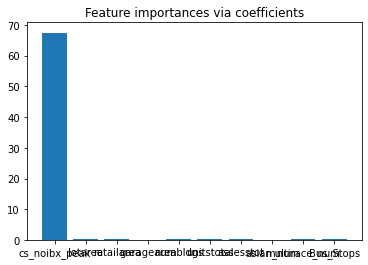

In [124]:
importance = np.abs(model.coef_)
feature_names = np.array(selected_features)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [125]:
importance = np.abs(model.coef_)
pos_index = len(importance[importance != 0])
idx_third = importance.argsort()[-pos_index]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()
name_features = list(np.array(selected_features)[idx_features])
feature_coef =-np.sort(-importance)
feature_coef = list(feature_coef[feature_coef != 0])
peak=pd.DataFrame(list(zip(name_features, feature_coef)),columns= ['Features','Coefficients'])

In [126]:
import altair as alt

alt.Chart(peak).mark_bar().encode(
    y=alt.Y('Features:N', sort='-x'),
    x='Coefficients'
).properties(
    title='Important Features of Ridge Weekday Evening Entries'
)

alt.Chart(...)

In [127]:
tic_fwd = time()
sfs_forward = SequentialFeatureSelector(
    model, n_features_to_select=10, direction="forward"
).fit(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
toc_fwd = time()

tic_bwd = time()
sfs_backward = SequentialFeatureSelector(
    model, n_features_to_select=10, direction="backward"
).fit(mg_noIBX_log[cols_peak], mg_noIBX_log['entries_weekday_evening'])
toc_bwd = time()

print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10 but corresponding boolean dimension is 31

In [59]:
sfs_backward.